In [13]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"): 
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

xn, xx, yn, yx = [-25,-12,63,67]
mapproj = cartopy.crs.PlateCarree()
sf = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe().set_index("names").loc[["Iceland"]]
sf["numbers"] = [0]

## Daily time series & spatial patterns

In [15]:
fl = glob.glob("data/tasmax_day_*.nc")

for fnm in fl:
    
    mdl = fnm.split("_")[2]+"_"+fnm.split("_")[4]
    print(mdl)
    
    da = convert_units_to(xr.open_dataset(fnm).tasmax, "degC")
    
    # daily time series
    rm = regionmask.mask_geopandas(sf, da, numbers = "numbers")
    ts = da.where(~np.isnan(rm)).mean(["lat", "lon"])
    ts.to_netcdf("data/tasmax-daily_highresSST_"+mdl+fnm[-21:])
    
    sp = da.sel(time = slice("1990","2020")).resample(time = "MS").mean().groupby("time.month")[5].mean("time")
    sp.to_netcdf("data/tasmax-spatial_highresSST_"+mdl+".nc")

EC-Earth3P_r1i1p1f1
CNRM-CM6-1_r1i1p1f2
EC-Earth3P-HR_r1i1p1f1
HadGEM3-GC31-HM_r1i1p1f1
HadGEM3-GC31-LM_r1i14p1f1
MPI-ESM1-2-HR_r1i1p1f1
HadGEM3-GC31-MM_r1i1p1f1
MPI-ESM1-2-XR_r1i1p1f1
CNRM-CM6-1-HR_r1i1p1f2


## Time series for trend fitting

In [66]:
fl = glob.glob("data/tasmax-daily_*.nc")
for fnm in fl:
    
    mdl = "_".join(fnm.split("_")[2:4])
    print(mdl)
    
    csv_fnm = "iceland-heat_tx7x-may_highresSST_"+mdl
    csv_fullpath = "ts/"+csv_fnm+".dat"
    if len(csv_fnm) > 61: print("! Filename too long: ", csv_fnm)

    # create header lines for upload to Climate Explorer 
    str1 = "# contact :: highresMIP tx7x - Iceland heat, c.barnes22@imperial.ac.uk"
    str2 = "# tx7x [degC] - May maxima of 7-day mean of daily maximum temperatures over Iceland at "+csv_fnm+".dat"
    head = "# year tx7x"

    ts = xr.open_dataset(fnm).tasmax
    
    if "height" in ts.coords: ts = ts.reset_coords("height", drop = True)
    ts_ann = ts.rolling(time = 7, center = True).mean().sel(time = ts.time.dt.month.isin([5])).resample(time = "AS").max()
    df = ts_ann.assign_coords(time = ts_ann.time.dt.year).rename(time = "year").dropna("year", "all").to_dataframe()
    
    # make .dat file
    ! echo "$str1 " > $csv_fullpath
    ! echo "$str2" >> $csv_fullpath
    ! echo "$head" >> $csv_fullpath
    df.to_csv(csv_fullpath, sep = " ", mode = "a", header = False)
    
clear_output(wait = False)

## Evaluation of seasonal cycle

In [35]:
era5 = xr.open_dataset("iera5_tmax_daily_eu_Iceland_firstyear--999_5lan_su.nc").tmax
era5 = era5.rolling(time = 1, center = True).mean().sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()

In [36]:
fl = glob.glob("data/tasmax-daily_highresSST_*.nc")
n = len(fl)
nc = 4
nr = int(np.ceil(n / nc))

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

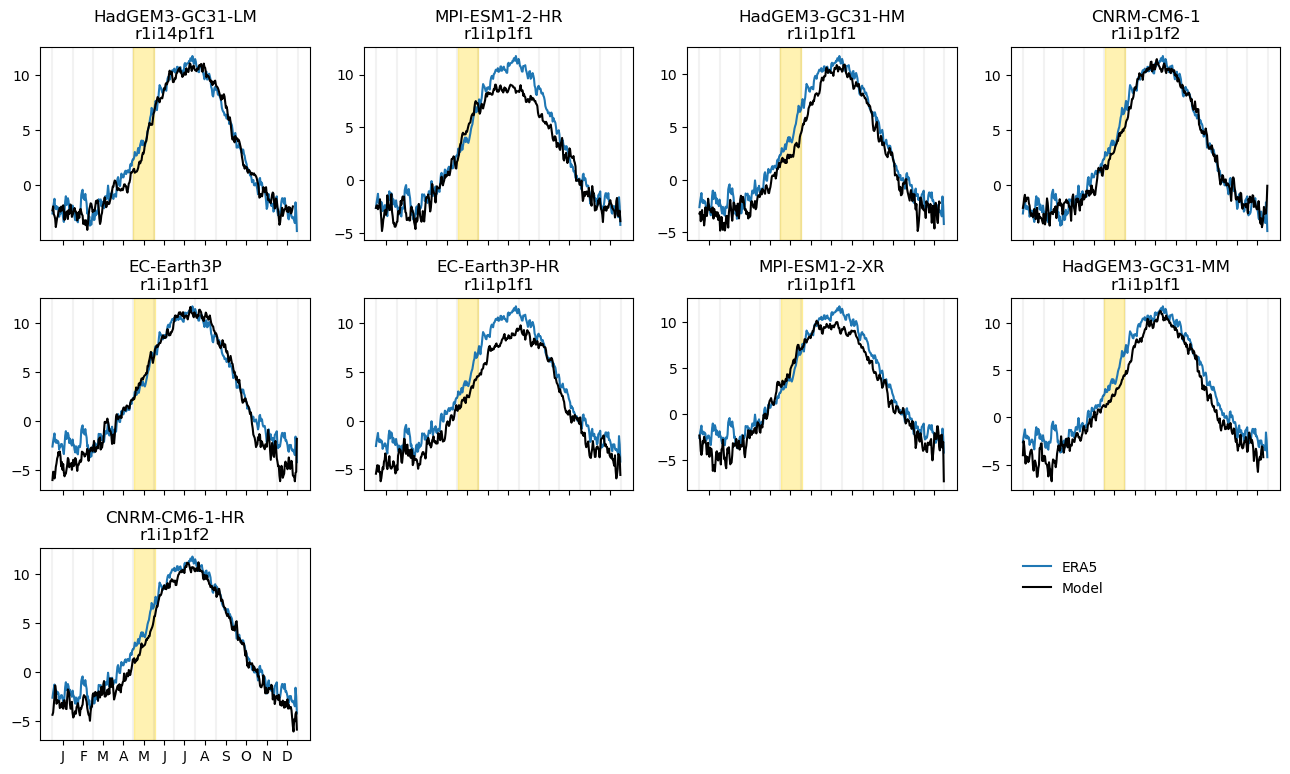

In [46]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(n):
    ax = axs.flatten()[i]
    fnm = fl[i]
    
    ax.plot(era5, label = "ERA5")
    
    ts = xr.open_dataset(fnm).tasmax
    sc = ts.rolling(time = 1, center = True).mean().sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
    ax.plot(sc, color = "k", label = "Model")
    ax.set_title("\n".join(fnm.split("_")[2:4]))
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
    # shade range of interest
    ylim = ax.get_ylim()
    dstart, dstop = ts.sel(time = ts.time.dt.strftime("%Y-%m-%d").isin(["2020-05-01", "2020-06-01"])).time.dt.dayofyear.values
    ax.add_patch(Rectangle((dstart, ylim[0]), dstop - dstart, ylim[1]-ylim[0], color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
leg = ax.get_legend_handles_labels()
axs[-1,-1].legend(*leg, loc = "upper left", frameon = False)
for i in range(n, nc*nr): axs.flatten()[i].set_axis_off()
    
plt.savefig("fig/mdl-eval_seasonal-cycle_highresmip.png")

## Evaluation of spatial pattern

In [54]:
era5 = xr.open_dataset("Tmax_era5_GIC_monclim_1991_2020.nc").tmax
era5 = convert_units_to(era5.sel(time = era5.time.dt.month.isin([5])).mean("time"), "degC")

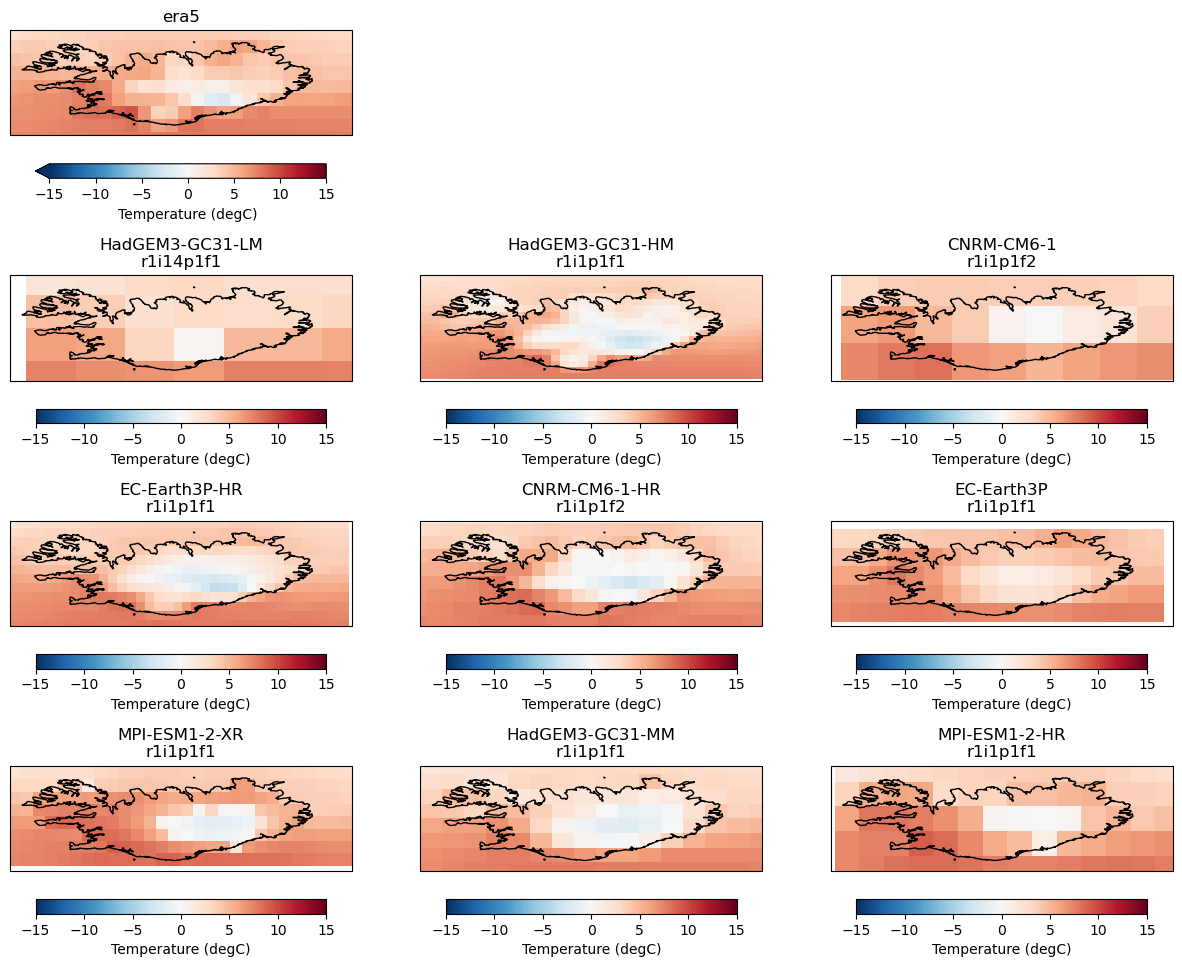

In [63]:
fl = glob.glob("data/tasmax-spatial_highresSST_*.nc")
n = len(fl)
nc = 3
nr = int(np.ceil(n / nc)) + 1

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 5, nr * 3), dpi = 100, sharex = True, 
                        subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})
plt.subplots_adjust(hspace = 0.3)

plot_kwargs = {"cmap" : "RdBu_r", "vmin" : -15, "vmax" : 15, 
               "cbar_kwargs" : {"location" : "bottom", "label" : "Temperature (degC)", "fraction" : 0.1, "shrink" : 0.85}}

# observed spatial patterns
for i in range(1):
    ax = axs[0,i]
    ds_nm = ["era5"][i]
    ds = eval(ds_nm)
    
    ds.plot(ax = ax, **plot_kwargs)
    ax.set_title(ds_nm)
    ax.coastlines()
for ax in axs[0,1:]: ax.set_axis_off()

# models
for i in range(n):
    ax = axs[1:,:].flatten()[i]
    fnm = fl[i]
    
    ds = xr.open_dataset(fnm).tasmax
    ds.plot(ax = ax, **plot_kwargs)
    ax.set_title("\n".join(fnm[:-3].split("_")[2:]))
    ax.coastlines()
    
for i in range(n+nc, nc*nr): axs.flatten()[i].set_axis_off()
    
plt.savefig("fig/mdl-eval_spatial-pattern_highresmip.png")